In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.version

'3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) \n[GCC 9.4.0]'

In [3]:
from cbf_opt import asif, cbf, dynamics
from refine_cbfs import cbf as refine_cbfs, dynamics as dynamics_hjr
import matplotlib.pyplot as plt
import hj_reachability as hj
import jax.numpy as jnp
import seaborn as sns

In [4]:
import matplotlib
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': '32',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'lines.linewidth': 6.,
})
import matplotlib.animation as anim

In [5]:
class ACC_Dynamics(dynamics.ControlAffineDynamics):

    
    def __init__(self, params, **kwargs):
        
        params['n_dims'] = 3
        params['control_dims'] = 1  # TODO: How to do this correctly?
        
        self.mass = params["mass"]
        self.g = params["g"]
        self.f0 = params["f0"]
        self.f1 = params["f1"]
        self.f2 = params["f2"]
        self.rolling_resistance = lambda x: self.f0 + self.f1 * x[1] + self.f2 * x[1] ** 2
        self.v0 = params["v0"]

        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state, time=0.0):
        return jnp.array([state[1], -1 / self.mass * self.rolling_resistance(state), self.v0 - state[1]])

    def control_matrix(self, state, time=0.0):
        return jnp.expand_dims(jnp.array([0, 1 / self.mass, 0]), axis=-1)

    def disturbance_jacobian(self, state, time=0.0):
        return jnp.expand_dims(jnp.zeros(3), axis=-1)

In [6]:
class ACC_CBF(cbf.ControlAffineCBF):
    def __init__(self, dynamics, params, **kwargs):
        super().__init__(dynamics, params, **kwargs)
        self.Th = params["Th"]
        self.cd = params["cd"]

    def vf(self, state, time=0.0):
        return state[2] - self.Th * state[1] - (state[1] - self.dynamics.v0) ** 2 / (2 * self.cd * self.dynamics.g)

    def vf_dt_partial(self, state, time=0.0):
        return 0.0
    
    def _grad_vf(self, state, time=0.0):
        return np.array([0.0, -self.Th * (state[1] - self.dynamics.v0) / (self.cd * self.dynamics.g), 1.0])

In [7]:
params = dict()
params["n_dims"] = 3
params["control_dims"] = 1
params["dt"] = 0.01
params["g"] = 9.81
params['v0'] = 14  # lead vehicle velocity
params['f0'] = 0.1  # friction coefficient
params['f1'] = 5  # friction coefficient
params['f2'] = 0.25  # friction coefficient
params['mass'] = 1650  # vehicle mass

acc = ACC_Dynamics(params)

In [8]:
cbf_params = dict()
cbf_params["cd"] = 0.3
cbf_params["Th"] = 1.8
acc_cbf = ACC_CBF(acc, cbf_params)

In [9]:
umax = cbf_params['cd'] * params['mass'] * params['g']
umin = -umax

## Offline: Warmstarting reachability with a *candidate* CBF

In [10]:
dyn_reachability = dynamics_hjr.HJControlAffineDynamics(acc, control_space=hj.sets.Box(jnp.array([umin]), jnp.array([umax])))

In [11]:
low_bound = jnp.array([0., 10., 0.])
high_bound = jnp.array([1e3, 40., 100.])
nbr_pts = (51, 101, 101)
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(low_bound, high_bound), nbr_pts)

acc_tabular_cbf = refine_cbfs.TabularControlAffineCBF(acc, grid=grid)

In [12]:
acc_tabular_cbf.tabularize_cbf(acc_cbf)

100%|██████████| 51/51 [00:14<00:00,  3.55it/s]


In [13]:
acc_tabular_cbf.vf_table.shape

(51, 101, 101)

Text(0, 0.5, 'Distance to vehicle')

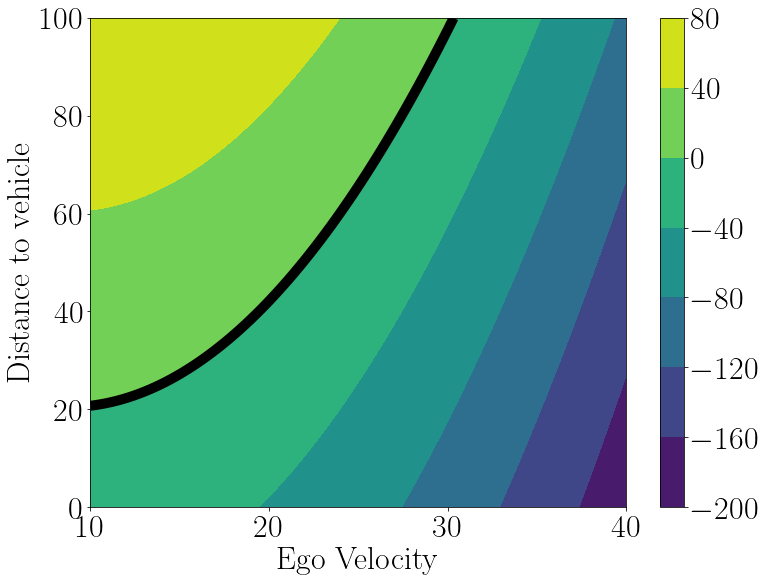

In [14]:
fig, ax = plt.subplots(figsize=(12, 9))
c = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2],
 acc_tabular_cbf.vf_table[0, ...].T)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], acc_tabular_cbf.vf_table[0, ...].T, levels=[0.0], colors='k', linewidths=10)
fig.colorbar(c)
ax.set_xlabel("Ego Velocity")
ax.set_ylabel("Distance to vehicle")

In [15]:
init_value = acc_tabular_cbf.vf_table
obstacle = grid.states[..., 2] - acc_cbf.Th * grid.states[..., 1]
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("medium",
                                                  value_postprocessor=backwards_reachable_tube(obstacle))

In [16]:
time = 0.
target_time = -20.0
times = jnp.linspace(time, target_time, 101)
target_values = hj.solve(solver_settings, dyn_reachability, grid, times, init_value)

100%|##########| 20.0000/20.0 [02:49<00:00,  8.45s/sim_s]


In [17]:
import numpy as np

In [18]:
acc_tabular_cbf.vf_table = np.array(target_values[-1])

In [19]:
# time = 0.
# target_time = -20.0
# times = jnp.linspace(time, target_time, 101)
# target_values_hjr = hj.solve(solver_settings, dyn_reachability, grid, times, obstacle)

Text(0, 0.5, 'Distance to vehicle')

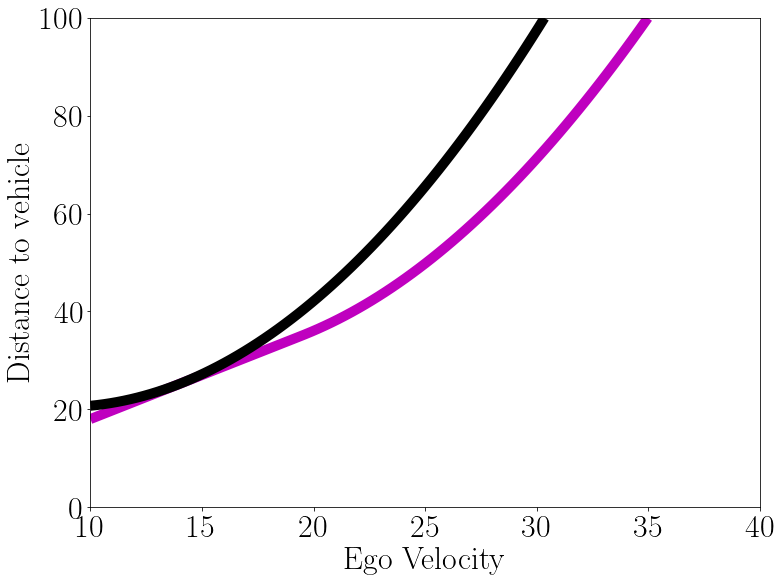

In [20]:
idx = 0
fig, ax = plt.subplots(figsize=(12, 9))
# c = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[idx][0].T)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], acc_tabular_cbf.vf_table[0, ...].T, levels=[0.0], colors='m', linewidths=10)
ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], target_values[idx][0].T, levels=[0.0], colors='k', linewidths=10)
ax.set_xlabel("Ego Velocity")
ax.set_ylabel("Distance to vehicle")

In [53]:
def render_frame(i, colorbar=False):
    global cont
    for c in cont.collections:
        c.remove()
    timestamp.set_text("Iteration = {}".format(i))
    cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[i][0].T, levels=[0], colors=gen_colors[2])

In [46]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [23]:
obstacle[0].shape

(101, 101)

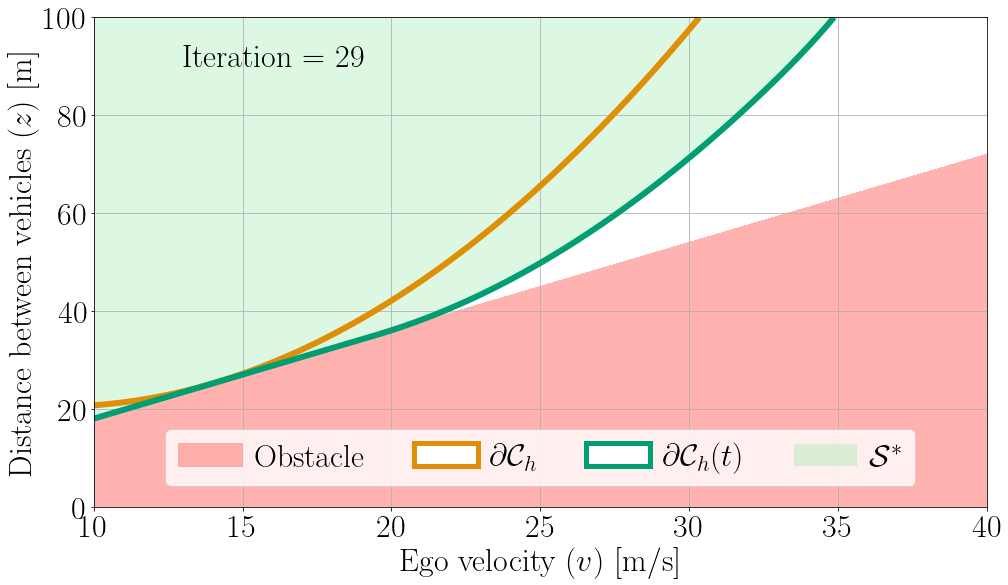

In [56]:
value_function = target_values
filename="acc/vf_time.mp4"
proxy = [] 

fig, ax = plt.subplots(figsize=(16, 9))
blue_colors = sns.color_palette("PuBuGn", 5).as_hex()
gen_colors = sns.color_palette("colorblind", 9).as_hex()
alt_colors = sns.color_palette("pastel", 9).as_hex()

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], obstacle[0].T, levels=[-100, 0], colors=alt_colors[3], alpha=0.8)
proxy += [plt.Rectangle((0,0),1,1, fc=alt_colors[3], ec=alt_colors[3], alpha=0.8) for pc in cs.collections]

cs = ax.contourf(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[-1][0].T, levels=[0, 200], colors=alt_colors[2], alpha=0.3)


cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[0][0].T, levels=[0], colors=gen_colors[1])
# proxy += [plt.Rectangle((0,0),1,1,ec = 'b', fc='white') 
#         for pc in cs.collections]

proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[1], fc='white', lw=5)
        for pc in cont.collections]

timestamp = ax.text(0.1, 0.9, "", transform=ax.transAxes)

cont = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[0][0].T, levels=[0], colors=gen_colors[2])
proxy += [plt.Rectangle((0,0),1,1,ec = gen_colors[2], fc='white', lw=5)
        for pc in cont.collections]
# cs = ax.contour(grid.coordinate_vectors[1], grid.coordinate_vectors[2], value_function[-1][0].T, levels=[0], colors='orange')
# proxy += [plt.Rectangle((0,0),1,1,ec = 'orange', fc='white')
#         for pc in cs.collections]
ax.grid()

proxy += [plt.Rectangle((0,0),1,1,fc = alt_colors[2], ec='white', alpha=0.3)
        for pc in cs.collections]

ax.legend(proxy, ["Obstacle", "$\partial \mathcal{C}_h$", "$\partial \mathcal{C}_h(t)$", "$\mathcal{S}^*$"], loc='center', bbox_to_anchor=(0.5, 0.1), ncol=4, columnspacing=1.5, handletextpad=0.4)

ax.set_ylabel("Distance between vehicles ($z$) [m]")
ax.set_xlabel("Ego velocity ($v$) [m/s]")


# ax.set_title("Ames 2016", fontsize=24)
# fig.suptitle("Adaptive Cruise Control")
render_frame(0, False)
animation = anim.FuncAnimation(fig, render_frame, value_function.shape[0] * 6 // 20, interval=100)
animation.save(filename, writer='ffmpeg')

## Online: Enforcing the CBF condition (Comparison)

In [23]:
import numpy as np

In [24]:
vd = 24

alpha = lambda x: 5 * x
nominal_policy = lambda x, t: np.atleast_1d(np.clip(-1000 * (x[1] - vd), umin, umax))
acc_asif = asif.ControlAffineASIF(acc, acc_cbf, alpha=alpha, nominal_policy=nominal_policy)
acc_asif_ws = asif.ControlAffineASIF(acc, acc_tabular_cbf, alpha=alpha, nominal_policy=nominal_policy)

TODO: Make simulating dynamics much more straightforward -> See e.g. Dawson

In [25]:
x0 = np.array([0, 25, 90])
states = [x0]
control = []
control_filt = []
control_filt_ws = []
x_filt = x0 
betas = []
states_filt = [x0]
x_filt_ws = x0
states_filt_ws = [x0]
vf_filt = [acc_cbf.vf(x0)]
vf_filt_ws = [acc_tabular_cbf.vf(x0, 0.)]

ts = np.arange(0, 20, params['dt'])

x = x0
for t in ts:  
    input_nom = nominal_policy(x, t)
    x = acc.step(x, input_nom)
    states.append(x)
    control.append(input_nom)

for t in ts:
    input_mod = np.atleast_1d(np.clip(acc_asif(x_filt), umin, umax))

    x_filt = np.array(acc.step(x_filt, input_mod))
    states_filt.append(x_filt)
    vf_filt.append(acc_cbf.vf(x_filt))
    control_filt.append(input_mod)

for t in ts:
    input_mod_ws = np.atleast_1d(np.clip(acc_asif_ws(x_filt_ws), umin, umax))

    x_filt_ws = np.array(acc.step(x_filt_ws, input_mod_ws))
    states_filt_ws.append(x_filt_ws)
    vf_filt_ws.append(acc_tabular_cbf.vf(x_filt_ws, t))
    control_filt_ws.append(input_mod_ws)


In [26]:
import seaborn as sns

In [27]:
pal = sns.color_palette("colorblind")

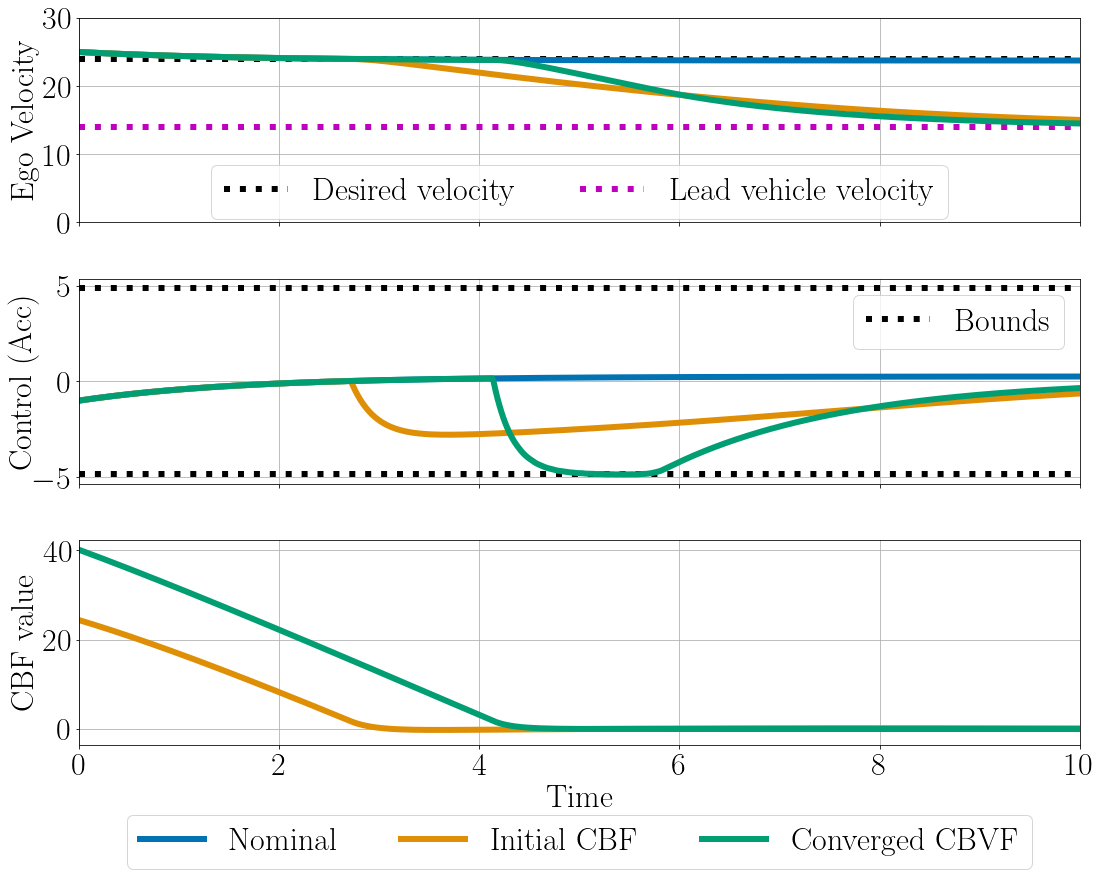

In [73]:
states = np.array(states)
states_filt = np.array(states_filt)
states_filt_ws = np.array(states_filt_ws)
sns.set_palette("colorblind")
ts = np.arange(0, 20, params['dt'])
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(16, 12))
# fig.suptitle("ASIF for highway example")
# ax[0].set_title("Distance to lead vehicle")
# ax[0].plot(ts[:states.shape[0]-1], states[1:,2], label='w/out ASIF')
# ax[0].plot(ts[:states_filt.shape[0]-1], states_filt[1:,2], label='w/ ASIF')
# ax[0].plot(ts[:states_filt_ws.shape[0]-1], states_filt_ws[1:,2], label='w/ ASIF WSed')
# ax[0].set_ylim([-10, 100])
ax[0].set_ylabel("Ego Velocity")
ax[0].plot(ts, vd * np.ones_like(ts), ':k', label='Desired velocity')
ax[0].plot(ts, params['v0'] * np.ones_like(ts), ':m', label='Lead vehicle velocity')
ax[0].plot(ts[:states.shape[0]-1], states[1:,1])
ax[0].plot(ts[:states_filt.shape[0]-1], states_filt[1:,1])
ax[0].plot(ts[:states_filt_ws.shape[0]-1], states_filt_ws[1:,1])
ax[0].set_ylim(0,30)
ax[0].legend(ncol=2, loc='center', bbox_to_anchor=(0.5, 0.15))
ax[1].plot(ts, np.ones_like(ts) * umax / 1000, ':k', label='Bounds')
ax[1].plot(ts, np.ones_like(ts) * umin / 1000, ':k', label='__nolegend__')
l1 = ax[1].plot(ts[:len(control)], np.array(control) / 1000)
l2 = ax[1].plot(ts[:len(control_filt)], np.array(control_filt) / 1000)
l3 = ax[1].plot(ts[:len(control_filt_ws)], np.array(control_filt_ws) / 1000)
ls = [l1, l2, l3]
leg = ax[1].legend([l[0] for l in ls], ["Nominal", "Initial CBF", "Converged CBVF"], ncol=3, loc='center', bbox_to_anchor=(0.5, -1.75))
ax[1].legend()
ax[1].set_ylabel("Control (Acc)")

# ax[1].ticklabel_format(axis='y', style='sci', useMathText=True, useOffset=False)

ax[2].plot(ts, vf_filt[1:], color=pal[1])
ax[2].plot(ts, vf_filt_ws[1:], color=pal[2])
ax[2].set_ylabel("CBF value")
ax[2].set_xlabel("Time")
# ax[2].set_xlabel("Time (s)")
for axi in ax:
    axi.grid()
    # axi.set_xlabel("Time")
    # axi.set_ylabel("Value")
    axi.yaxis.set_label_coords(-0.04, 0.5)
    axi.set_xlim([ts[0], 10])

# ax[1].yaxis.set_label_coords(-0.04, 0.5)

# fig.suptitle("Adaptive Cruise Control - Ames 2014", fontsize=30)
fig.tight_layout()
fig.subplots_adjust(wspace=-0.05)
ax[1].add_artist(leg)
fig.savefig("acc/acc_highway_asif.pdf", bbox_inches='tight')

In [ ]:
import pickle as pkl
traj_data = dict()
traj_data['nominal'] = {'times': ts, 'state': np.array(states), 'control': np.array(control)}
traj_data['cbf'] = {'times': ts, 'state': np.array(states_filt), 'control': np.array(control_filt), 'vf': np.array(vf_filt)}
traj_data['cbvf'] = {'times': ts, 'state': np.array(states_filt_ws), 'control': np.array(control_filt_ws), 'vf': np.array(vf_filt_ws)}
traj_data['x_start'] = x0
# traj_data['x_goal'] = x_goal
traj_data['target_values'] = target_values
pkl.dump(traj_data, open("acc/traj_data_conservative_cbf.pkl", "wb"))

In [ ]:
traj_data = pkl.load(open("quad_2d/traj_data_invalid_cbf.pkl", "rb"))
nominal = traj_data['nominal']
cbf_traj = traj_data['cbf']
cbvf_traj = traj_data['cbvf']
states = nominal['state']
control = nominal['control']
ts = nominal['times']
states_filt = cbf_traj['state']
control_filt = cbf_traj['control']
vf_filt = cbf_traj['vf']
states_filt_ws = cbvf_traj['state']
control_filt_ws = cbvf_traj['control']
vf_filt_ws = cbvf_traj['vf']

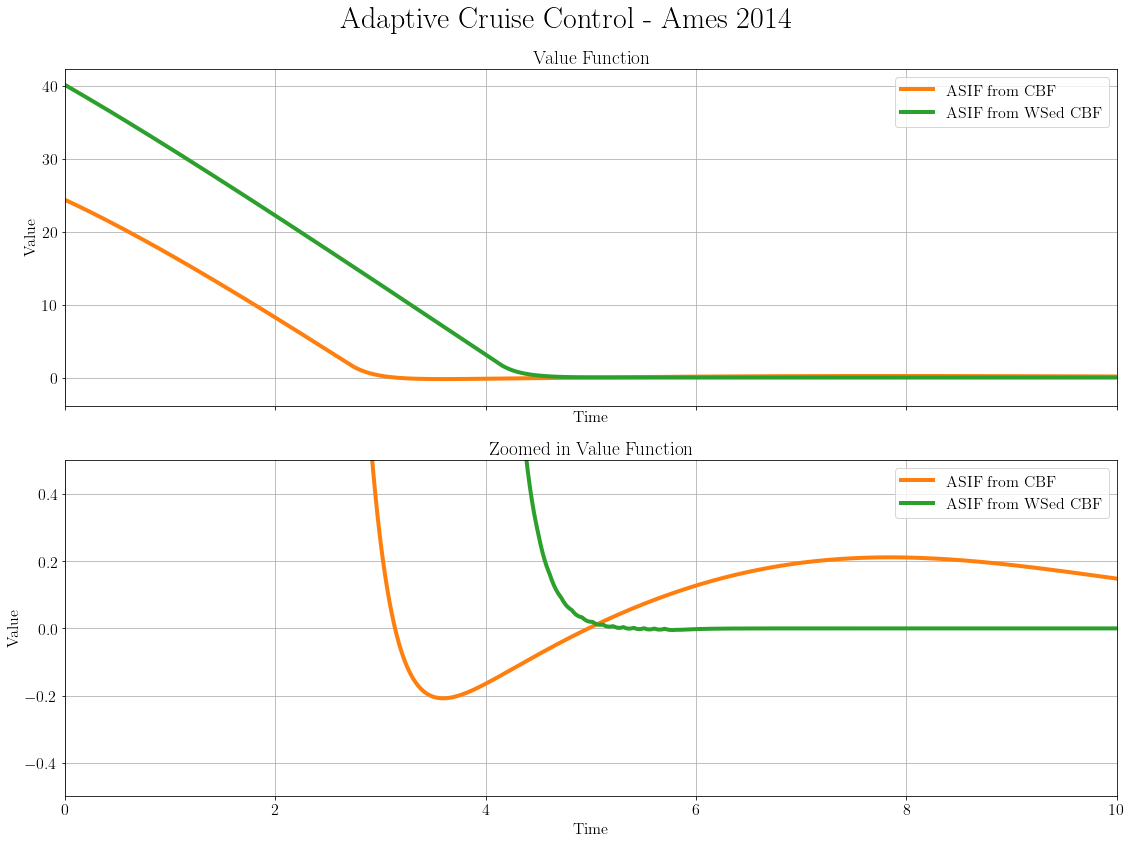

In [76]:
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 12))
ax[0].set_title("Value Function")
next(ax[0]._get_lines.prop_cycler)
ax[0].plot(ts, vf_filt[1:], label='ASIF from CBF')
ax[0].plot(ts, vf_filt_ws[1:], label='ASIF from WSed CBF')
ax[0].legend()

ax[1].set_title("Zoomed in Value Function")
next(ax[1]._get_lines.prop_cycler)
ax[1].plot(ts, vf_filt[1:], label='ASIF from CBF')
ax[1].plot(ts, vf_filt_ws[1:], label='ASIF from WSed CBF')
ax[1].set_ylim([-0.5, 0.5])
ax[1].legend()

for axi in ax:
    axi.grid()
    axi.set_xlabel("Time")
    axi.set_ylabel("Value")
    axi.set_xlim([ts[0], 10])

fig.suptitle("Adaptive Cruise Control - Ames 2014", fontsize=30)
fig.tight_layout()